In [554]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
import seaborn as sns


In [555]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from matplotlib import pyplot
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox


In [556]:
def diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff


def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [557]:
zillow = pd.read_csv('zillow-carlifornia.csv', parse_dates=True,squeeze=True)
zillow


,Date,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
0,2008-02-29,470000.0,5.29,6.3
1,2008-03-31,441000.0,5.44,6.2
2,2008-04-30,460000.0,5.42,6.4
3,2008-05-31,429000.0,5.47,6.3
4,2008-06-30,437500.0,5.60,6.2
...,...,...,...,...
102,2016-08-31,NaN,3.46,4.8
103,2016-09-30,NaN,3.42,5.0
104,2016-10-31,NaN,3.36,5.0
105,2016-11-30,NaN,3.47,4.8


In [558]:
zillow.shape

(107, 4)

# Distribution of Median sold price 

Text(0.5, 1.0, 'Box plot of MedianSoldPrice_AllHomes.California')

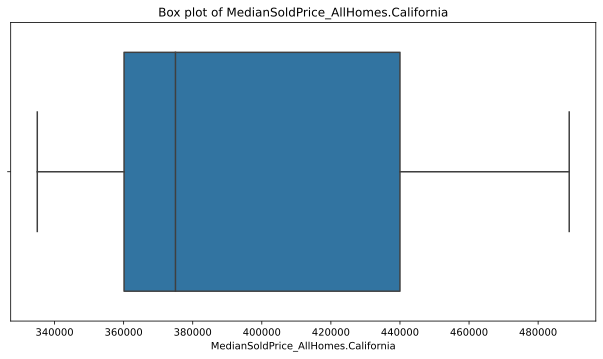

In [559]:
plt.figure(figsize=(10.5, 5.5))
g = sns.boxplot(zillow['MedianSoldPrice_AllHomes.California'])
g.set_title('Box plot of MedianSoldPrice_AllHomes.California')



In [560]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
zillow['scaled_Med'] = scaler.fit_transform(np.array(zillow['MedianSoldPrice_AllHomes.California']).reshape(-1, 1))

In [561]:
# split_date = datetime.datetime(year=2011, month=1, day=1, hour=0)
train_data  = zillow.loc[zillow['Date']<'2016-01-01']
test_data = zillow.loc[zillow['Date']>'2016-01-01']
print('Shape of train:', train_data.shape)
print('Shape of test:', test_data.shape)



Shape of train: (95, 5)
Shape of test: (12, 5)


In [562]:
train_data.head()

,Date,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate,scaled_Med
0,2008-02-29,470000.0,5.29,6.3,0.876623
1,2008-03-31,441000.0,5.44,6.2,0.688312
2,2008-04-30,460000.0,5.42,6.4,0.811688
3,2008-05-31,429000.0,5.47,6.3,0.610390
4,2008-06-30,437500.0,5.60,6.2,0.665584


In [563]:
test_data.reset_index(drop=True, inplace=True)

In [564]:
# Extract year 
import datetime

train_data['year'] = pd.DatetimeIndex(train_data['Date']).year
train_data.head()

<ipython-input-564-9b93f82ef5f6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['year'] = pd.DatetimeIndex(train_data['Date']).year


,Date,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate,scaled_Med,year
0,2008-02-29,470000.0,5.29,6.3,0.876623,2008
1,2008-03-31,441000.0,5.44,6.2,0.688312,2008
2,2008-04-30,460000.0,5.42,6.4,0.811688,2008
3,2008-05-31,429000.0,5.47,6.3,0.610390,2008
4,2008-06-30,437500.0,5.60,6.2,0.665584,2008


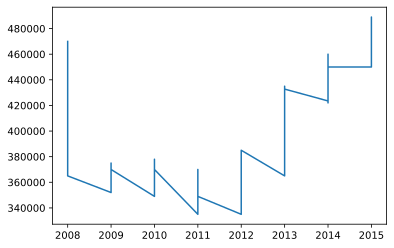

In [565]:
plt.plot(train_data['year'],train_data['MedianSoldPrice_AllHomes.California'])

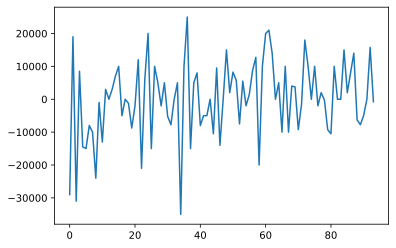

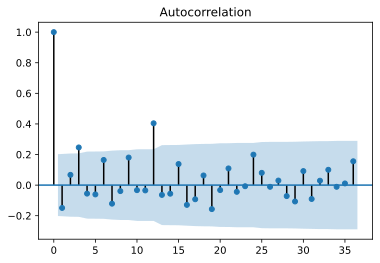

Results of Dickey-Fuller Test:
Test Statistic                 -3.088139
p-value                         0.027443
#Lags Used                     11.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [566]:
d1 = diff(train_data['MedianSoldPrice_AllHomes.California'])
plt.plot(d1) 
plot_acf(d1,lags=36) 
plt.show()
adf_test(d1)

In [567]:
# Univariate ETS
train_size = int(len(train_data) * 0.90)
train_data, valid_data = train_data[:train_size], train_data[train_size:]
train_data

,Date,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate,scaled_Med,year
0,2008-02-29,470000.0,5.29,6.3,0.876623,2008
1,2008-03-31,441000.0,5.44,6.2,0.688312,2008
2,2008-04-30,460000.0,5.42,6.4,0.811688,2008
3,2008-05-31,429000.0,5.47,6.3,0.610390,2008
4,2008-06-30,437500.0,5.60,6.2,0.665584,2008
...,...,...,...,...,...,...
80,2014-10-31,450500.0,4.19,6.3,0.750000,2014
81,2014-11-30,440000.0,4.03,6.0,0.681818,2014
82,2014-12-31,450000.0,3.90,6.2,0.746753,2014
83,2015-01-31,450000.0,3.85,6.2,0.746753,2015


In [568]:
train = train_data['MedianSoldPrice_AllHomes.California']
train = np.array(train)
train = train.reshape(train.shape[0], 1)

valid = valid_data['MedianSoldPrice_AllHomes.California']
valid = np.array(valid)
valid = valid.reshape(valid.shape[0], 1)
# train

In [569]:
# 1. Use the history data to select ONE ETS model
def evaluate_es_model_mape(X,Trend, Seasonal,m,damped=True):
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ExponentialSmoothing(history, trend=Trend,seasonal=Seasonal,seasonal_periods=m, damped=damped)
        res = model.fit()
        yhat = res.forecast()[0] #predict one step
        predictions.append(yhat) #store prediction
        history.append(test[t]) #store observation
        # calculate out of sample error
    mape=(np.abs(np.array(test)-np.array(predictions))/np.array(test)).mean()
    return mape

In [156]:
X= np.array(train)
mape_1=evaluate_es_model_mape(X, Trend="additive", Seasonal="additive",m=12,damped=False)
mape_2=evaluate_es_model_mape(X, Trend="multiplicative", Seasonal="additive",m=12,damped=True)
mape_3=evaluate_es_model_mape(X, Trend="additive", Seasonal="multiplicative",m=12,damped=True)
mape_4=evaluate_es_model_mape(X, Trend="multiplicative", Seasonal="multiplicative",m=12,damped=True)
mape_5=evaluate_es_model_mape(X, Trend=None, Seasonal="additive",m=12,damped=False)


/Users/efar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/Users/efar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/Users/efar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/Users/efar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/Users/efar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWar

/Users/efar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/Users/efar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/Users/efar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/Users/efar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/Users/efar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWar

/Users/efar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/Users/efar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/Users/efar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/Users/efar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/Users/efar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWar

In [157]:
mapes = [mape_1,mape_2, mape_3, mape_4, mape_5,mape_6]

for mape in mapes:  
    print(mapes.index(mape), mape)
print()      
print('the minimun mape is {} and is at index {}'.format(min(mapes), mapes.index(min(mapes))))

0 0.046375020342161184
1 nan
2 0.036197392236773686
3 nan
4 0.03400073765681662
5 0.036620588304024794

the minimun mape is 0.03400073765681662 and is at index 4


In [158]:
# The model of choice is mape_1
# mape_1=evaluate_es_model_mape(X, Trend="multiplicative", Seasonal="additive",m=12,damped=True)


In [570]:
model_ets=ExponentialSmoothing(train, trend='multiplicative', seasonal="add", damped=True, seasonal_periods=12)
result_ets=model_ets.fit()
pred_ets=result_ets.forecast(len(valid))
# pred_ets.index=test_data.index

pred = np.array(pred_ets)
pred = pred.reshape(pred.shape[0], 1)


/Users/efar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


In [571]:
rmse1 = np.sqrt(np.mean(np.square(valid - pred)))

In [572]:
rmse1

7164.610370581935

In [599]:
model1 = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12,damped=True)
model2 = ExponentialSmoothing(train, trend="add", seasonal="mul", seasonal_periods=12, damped=False)
model3 = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=12, damped=False)
model4 = ExponentialSmoothing(train, trend='mul', seasonal="add", seasonal_periods=12, damped=False)
model5 = ExponentialSmoothing(train, trend=None, seasonal="additive", seasonal_periods=12, damped=False)


In [600]:
fit = model1.fit()
pred = fit.forecast(len(valid))
pred = np.array(pred_ets)
pred = pred.reshape(pred.shape[0], 1)

fit2 = model2.fit()
pred2 = fit2.forecast(len(valid))
pred2 = np.array(pred2)
pred2 = pred2.reshape(pred2.shape[0], 1)

fit3 = model3.fit()
pred3 = fit3.forecast(len(valid))
pred3 = np.array(pred3)
pred3 = pred3.reshape(pred3.shape[0], 1)

fit4 = model4.fit()
pred4 = fit4.forecast(len(valid))
pred4 = np.array(pred4)
pred4 = pred4.reshape(pred4.shape[0], 1)

fit5 = model5.fit()
pred5 = fit5.forecast(len(valid))
pred5 = np.array(pred5)
pred5 = pred5.reshape(pred5.shape[0], 1)

/Users/efar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/Users/efar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/Users/efar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


In [601]:
rmse1 = np.sqrt(np.mean(np.square(valid - pred)))
rmse2 = np.sqrt(np.mean(np.square(valid - pred2)))
rmse3 = np.sqrt(np.mean(np.square(valid - pred3)))
rmse4 = np.sqrt(np.mean(np.square(valid - pred4)))
rmse5 = np.sqrt(np.mean(np.square(valid - pred5)))


In [602]:
remses = [rmse1, rmse2, rmse3, rmse4, rmse5]
for i,r in enumerate(remses):
    print('rmse-{}'.format(i+1),r)


rmse-1 7164.610370581935
rmse-2 10848.198225780665
rmse-3 13970.482613179835
rmse-4 14247.78547962269
rmse-5 16131.053618208227


### Plot the best model 
As we can see the line of the forcast is close to the actual 

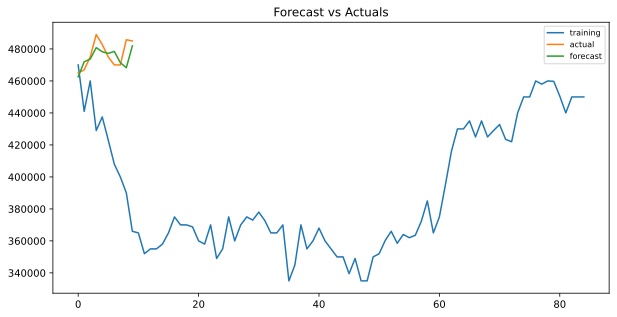

In [603]:
# Plotting the actual vs. forecast

plt.figure(figsize=(10,5))
plt.plot(train, label='training')
plt.plot(valid, label='actual')
plt.plot(pred, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper right', fontsize=8)
plt.show()


### Plot all the  models

As we can see the line of the forcasts is close to the actual


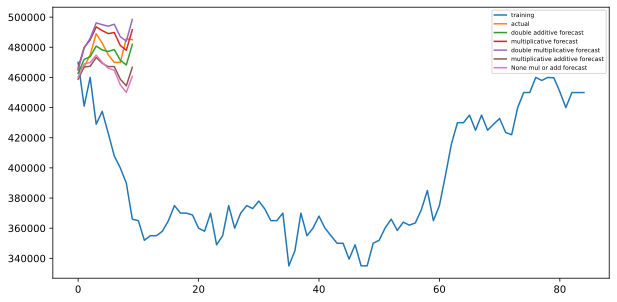

In [605]:
plt.figure(figsize=(10,5))
plt.plot(train, label='training')
plt.plot(valid, label='actual')
plt.plot(pred, label='double additive forecast')
plt.plot(pred2, label='multiplicative forecast')
plt.plot(pred3, label='double multiplicative forecast')
plt.plot(pred4, label='multiplicative additive forecast')
plt.plot(pred5, label='None mul or add forecast')
plt.legend(loc='upper right', fontsize=6)
plt.show()

# Test the selected model with unseen data from  2016

In [606]:
train_data  = zillow.loc[zillow['Date']<'2016-01-01']
train_data = train_data['MedianSoldPrice_AllHomes.California']
train_data = np.array(train_data)
train_data=train_data.reshape(train_data.shape[0], 1)
train_data.shape

(95, 1)

In [607]:
test = pd.read_csv('test.csv')
test = np.array(test['Median House Price'])
test = test.reshape(test.shape[0], 1)


In [608]:
# Perform Forcast on the selected model 

In [616]:
model1 = ExponentialSmoothing(train_data, trend="add", seasonal="add", seasonal_periods=12,damped=True)
fit = model1.fit()
pred = fit.forecast(len(test))
pred = np.array(pred)
pred = pred.reshape(pred.shape[0], 1)
rmse1 = np.sqrt(np.mean(np.square(test - pred)))
rmse1


7686.880808734778

### Plot the best model 

As we can see the line of the best forcast is close to the actual from the test data


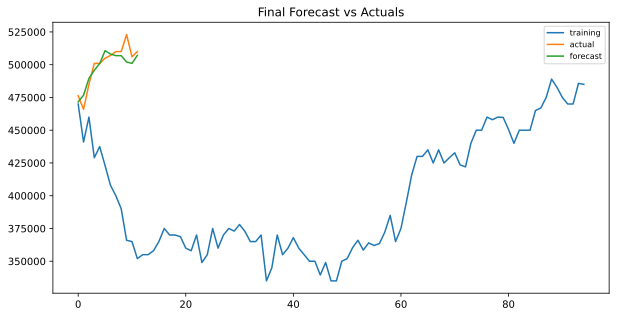

In [614]:
plt.figure(figsize=(10,5))
plt.plot(train_data, label='training')
plt.plot(test, label='actual')
plt.plot(pred, label='forecast')
plt.title('Final Forecast vs Actuals')
plt.legend(loc='upper right', fontsize=8)
plt.show()